In [20]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Uso de GPU (Local)
import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Activar uso de GPU
device = torch.device('cuda' if USE_GPU else 'cpu')                            # Dispositivo (GPU o CPU)
print("GPU de uso: ", torch.cuda.get_device_name())

# Importación librerías
import os                                                                      # Librería para interactuar con el sistema operativo
import pandas as pd                                                            # Librería para manipulación de datos
import matplotlib.pyplot as plt                                                # Librería para visualización de datos
import seaborn as sns                                                          # Librería para visualización de datos
import numpy as np                                                             # Librería para manipulación de arrays y matrices

from sklearn.model_selection import train_test_split                           # División de datos en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer                    # Vectorización de texto
from sklearn.preprocessing import MultiLabelBinarizer                          # Binarización de etiquetas múltiples
from sklearn.multiclass import OneVsRestClassifier                             # Vectorización de etiquetas múltiples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier     # Modelos de bosque aleatorio
from sklearn.linear_model import LogisticRegression                            # Regresión logística
from sklearn.metrics import r2_score, roc_auc_score                            # Métricas de evaluación

import torch.nn as nn                                                          # Redes neuronales
import torch.optim as optim                                                    # Optimizadores de PyTorch
from torch.utils.data import DataLoader, TensorDataset                         # Cargador de datos de PyTorch

GPU de uso:  NVIDIA GeForce RTX 3090 Ti


In [22]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [23]:
# Verifica que son listas
print(type(dataTraining['genres'].iloc[0]))  # Debe decir: <class 'str'> o <class 'list'>

# Si los géneros están como strings, convertirlos a listas
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

<class 'str'>


In [24]:
# Binarizar
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

In [ ]:
# 3. Generate BERT embeddings (this is the part you were missing)
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Generate embeddings for training data
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)

# Generate embeddings for test data (important!)
dataTesting['plot_clean_bert'] = dataTesting['plot'].progress_apply(get_bert_embeddings)

# 4. Now proceed with your model
X = np.vstack(dataTraining['plot_clean_bert'].values)
y = y_genres

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 3383/3383 [00:17<00:00, 198.26it/s]


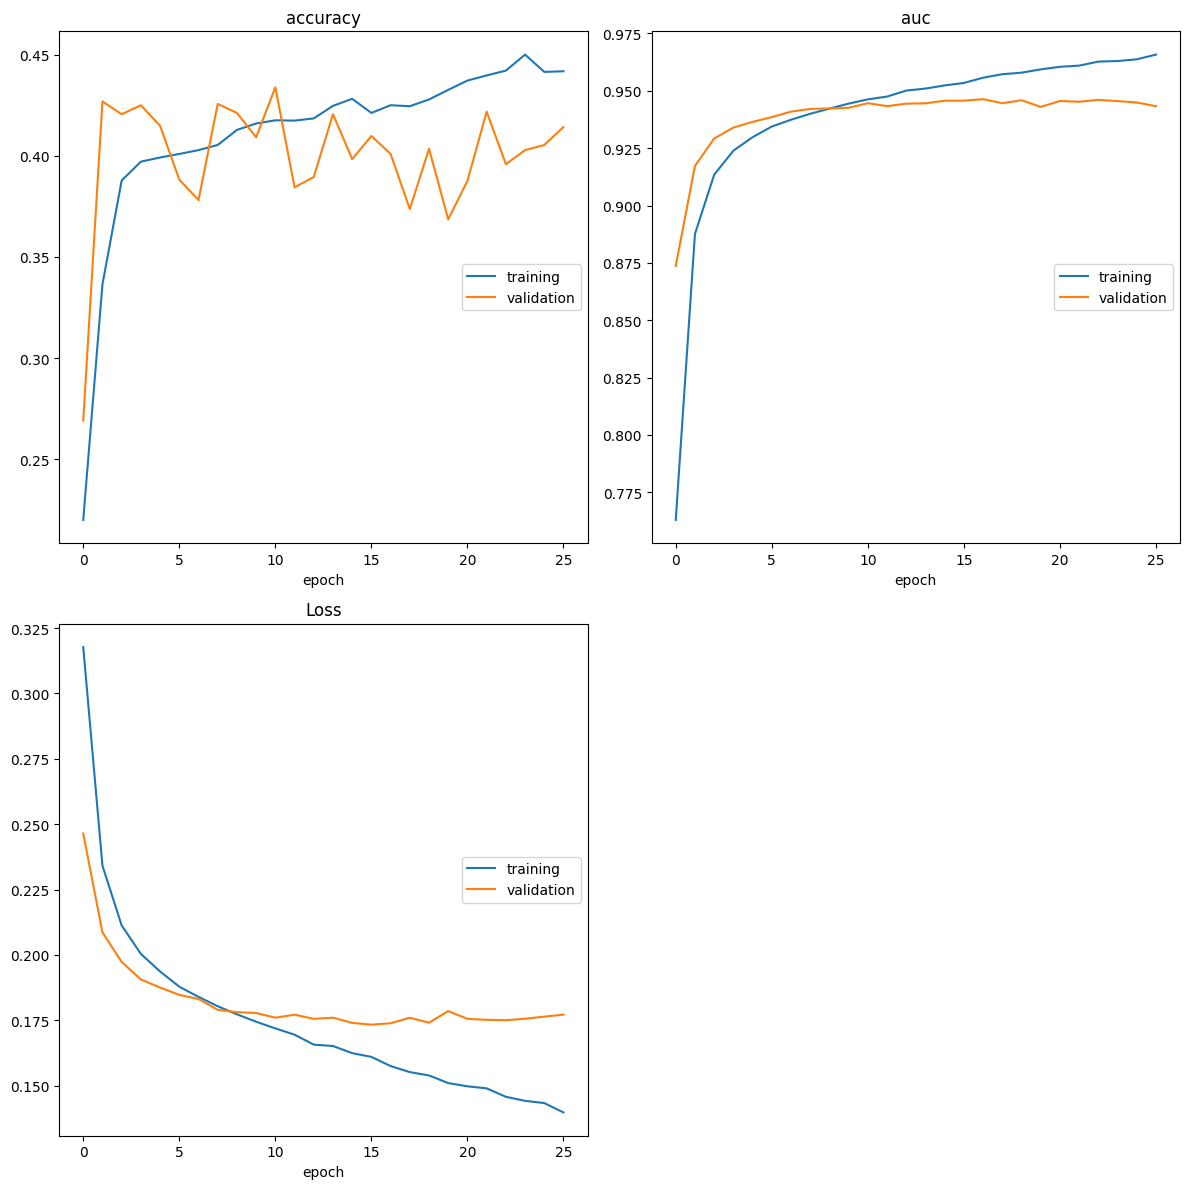

accuracy
	training         	 (min:    0.220, max:    0.450, cur:    0.442)
	validation       	 (min:    0.269, max:    0.434, cur:    0.414)
auc
	training         	 (min:    0.763, max:    0.966, cur:    0.966)
	validation       	 (min:    0.874, max:    0.946, cur:    0.943)
Loss
	training         	 (min:    0.140, max:    0.318, cur:    0.140)
	validation       	 (min:    0.173, max:    0.246, cur:    0.177)
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4377 - auc: 0.9656 - loss: 0.1403 - val_accuracy: 0.4142 - val_auc: 0.9433 - val_loss: 0.1772

Evaluación en conjunto de validación:
Loss: 0.1733, Accuracy: 0.4098, AUC: 0.9457
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Modelo guardado como modelo_nn.keras


In [28]:
# Red neuronal con BERT embeddings para clasificación multilabel (mejorada con optimizador AdamW y ajustes de hiperparámetros)

output_var = y_train.shape[1]
dims = X_train.shape[1]
print(output_var, 'output variables')
print(dims, 'input variables')

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Modelo con AdamW y mejoras

def nn_model_params(optimizer='adamw',
                   neurons=384,
                   batch_size=64,
                   epochs=150,
                   activation='relu',
                   patience=7,
                   loss='binary_crossentropy'):
    K.clear_session()
    model = Sequential()
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(output_var, activation='sigmoid'))

    model.compile(optimizer=AdamW(learning_rate=0.0005),
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])

    early_stopping = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, PlotLossesKeras()],
                        verbose=1)

    return model, history

# Parámetros mejorados
params = {
    'optimizer': 'adamw',
    'neurons': 384,
    'batch_size': 64,
    'epochs': 150,
    'activation': 'relu',
    'patience': 10,
    'loss': 'binary_crossentropy'
}

model, history = nn_model_params(**params)

print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

model.save('modelo_nn.keras')
print("Modelo guardado como modelo_nn.keras")

In [29]:
roc_auc_test = roc_auc_score(y_genres, model.predict(X), average='macro')
roc_auc_test

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


np.float64(0.9476016039797971)

## Aplicación del modelo a datos de test

In [30]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [31]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_NN_Hiper.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.008704,0.017352,0.000360,0.006276,0.029503,0.043640,0.000169,0.880786,0.003485,0.082645,...,0.002142,0.284565,0.000084,0.585337,0.023638,0.000818,0.000096,0.527398,0.001135,0.004953
4,0.389657,0.036047,0.000727,0.098312,0.112756,0.716488,0.013627,0.856947,0.004220,0.003045,...,0.001777,0.033975,0.001921,0.122898,0.004597,0.001761,0.009760,0.500288,0.028244,0.002606
5,0.075395,0.005083,0.000367,0.059506,0.044806,0.865499,0.008401,0.818037,0.002495,0.003701,...,0.001562,0.431821,0.001513,0.092424,0.006579,0.001143,0.000913,0.771011,0.001536,0.002884
6,0.511346,0.496226,0.005860,0.031893,0.152711,0.061621,0.003138,0.680790,0.016306,0.024263,...,0.004237,0.080860,0.001229,0.198124,0.112834,0.007123,0.003547,0.508417,0.448453,0.008147
7,0.011215,0.009860,0.002004,0.002386,0.103325,0.020764,0.000786,0.175696,0.007944,0.104965,...,0.003637,0.208813,0.000063,0.066734,0.620681,0.005928,0.000046,0.366416,0.000113,0.000516
